### 라이브러리 설치

In [1]:
! pip install librosa

In [2]:
! pip install imutils

In [3]:
! pip install opencv-python

In [4]:
! pip install sklearn

### 라이브러리 import

In [5]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from sklearn.svm import SVC
from imutils import paths

import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import wave, array
import numpy as np
import pickle
import sys
import os

import warnings
warnings.filterwarnings('ignore')

In [6]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum > /dev/null

지정된 경로를 찾을 수 없습니다.


In [7]:
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

In [8]:
# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

### 코딩 시작

In [9]:
dataset_folder = 'C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일' # 녹음 파일이 저장되어있는 경로
files = paths.list_files(dataset_folder) # 해당 경로에 있는 모든 파일 이름을 list로 저장

dataset = []
label = []
for l in files: # 모든 파일에 대하여 
    y, sr = librosa.load(l, sr=16000) # librosa로 wav 파일 불러오기(16000Hz)
    dataset.append([y, sr]) # dataset이라는 list에 불러온 wav파일 결과 저장하기
    label.append(os.path.basename(l)) # wav 파일의 이름을 label list에 저장 (예를 들어 김기백.wav는 김기백.wav로 이름만 저장)

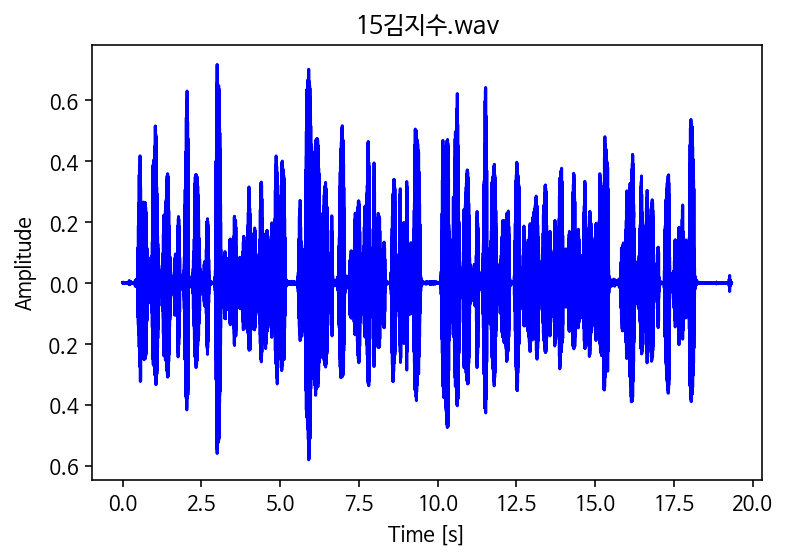

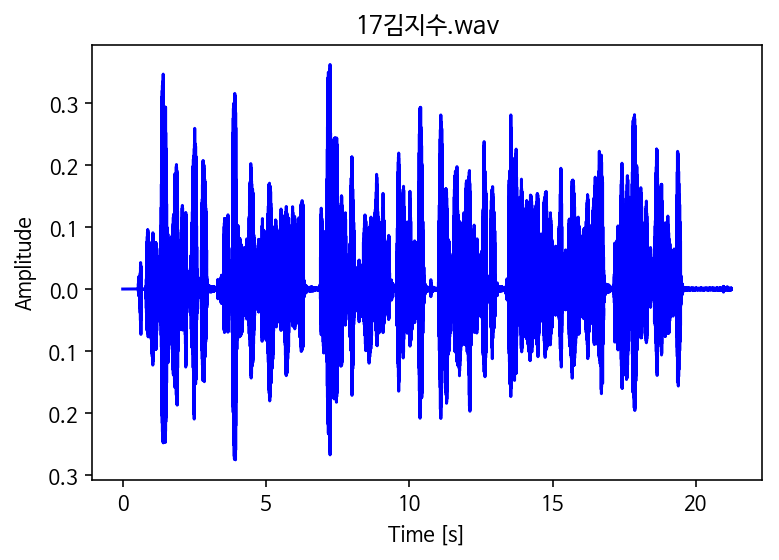

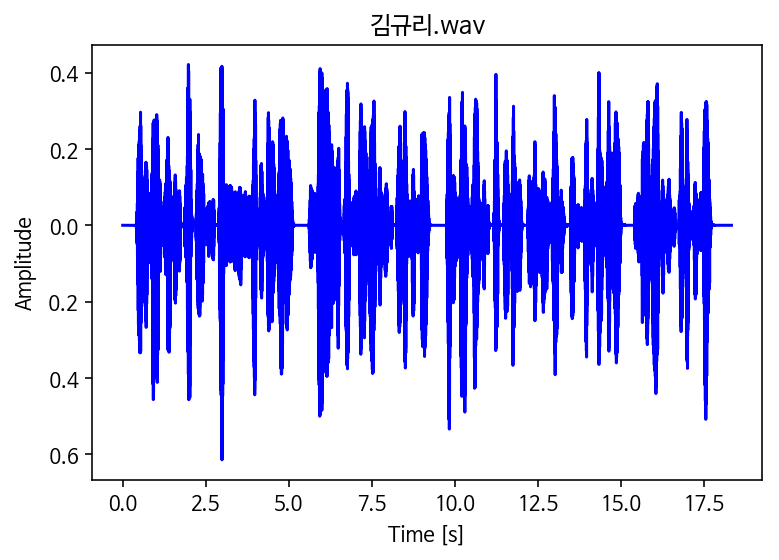

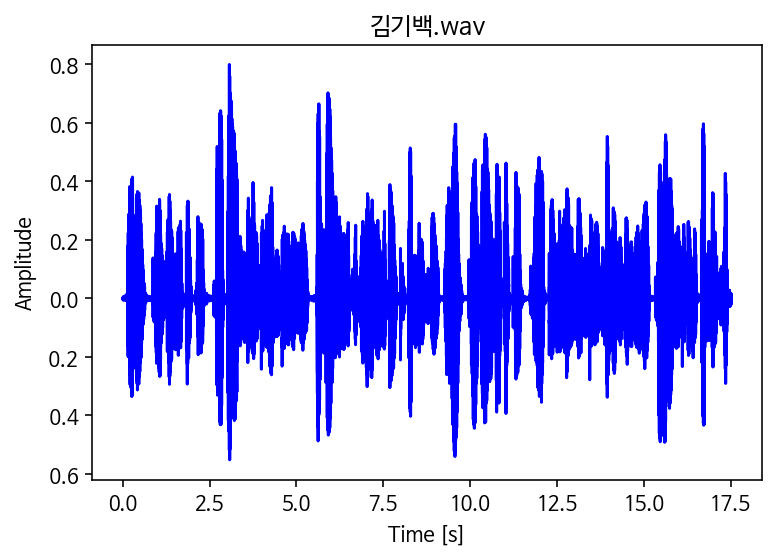

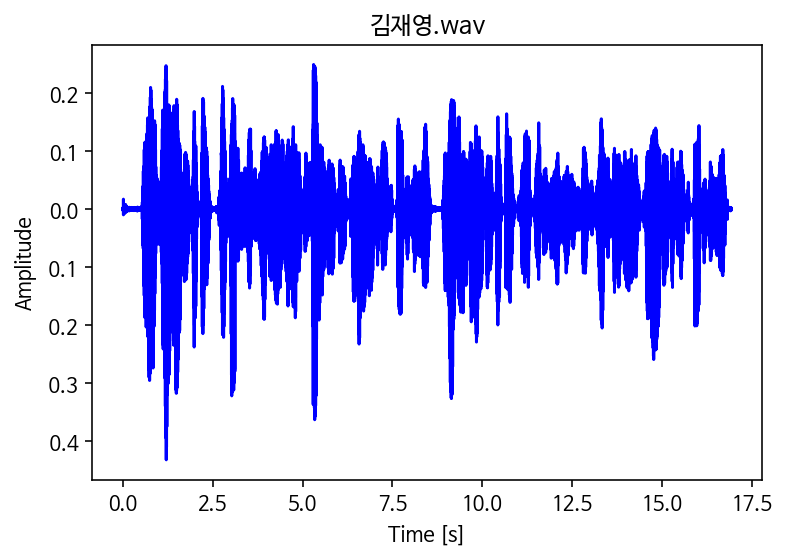

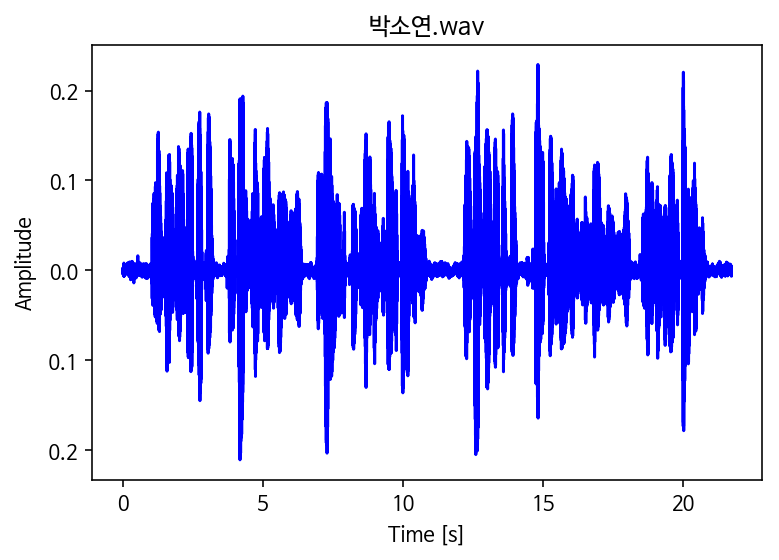

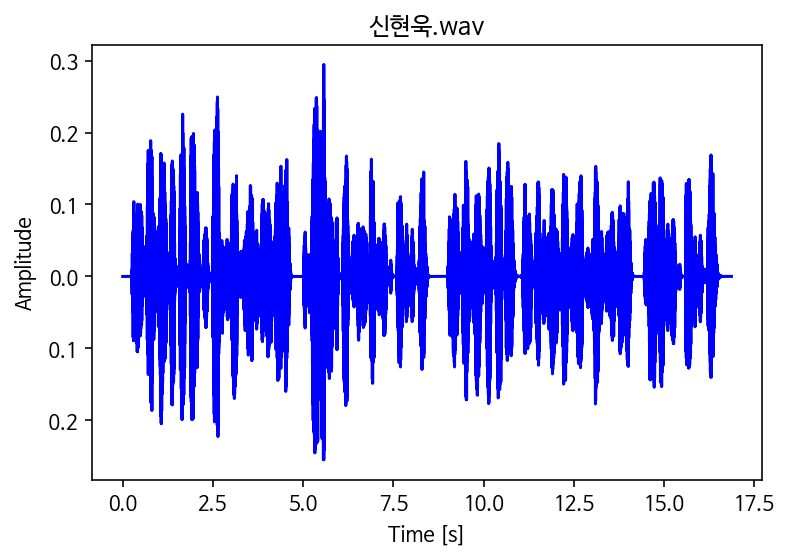

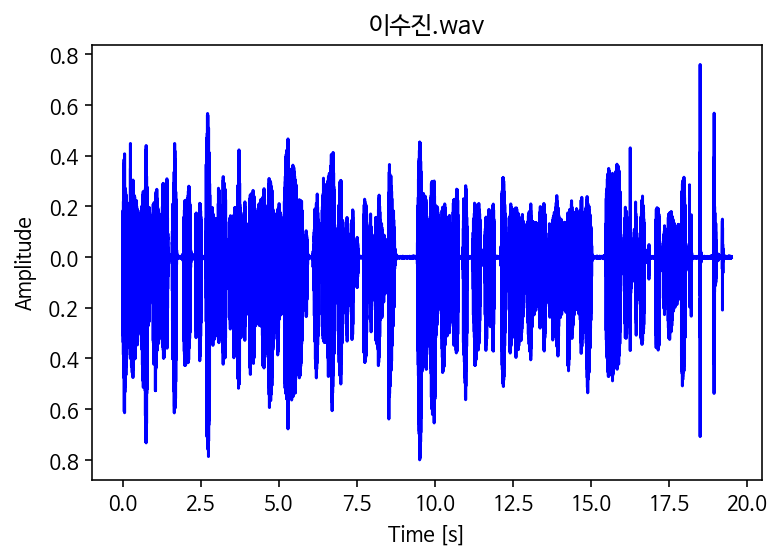

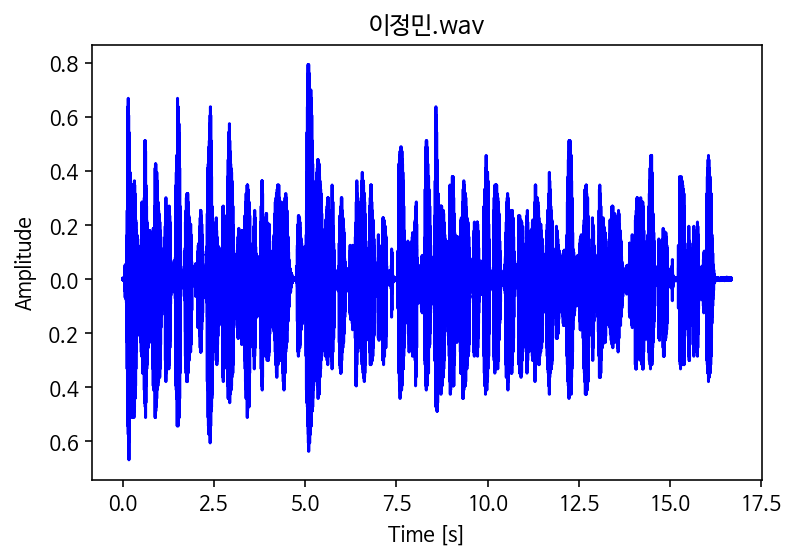

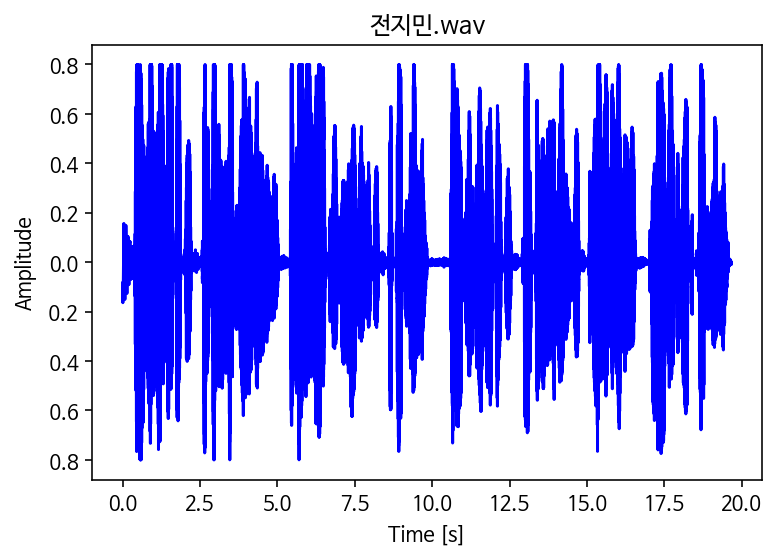

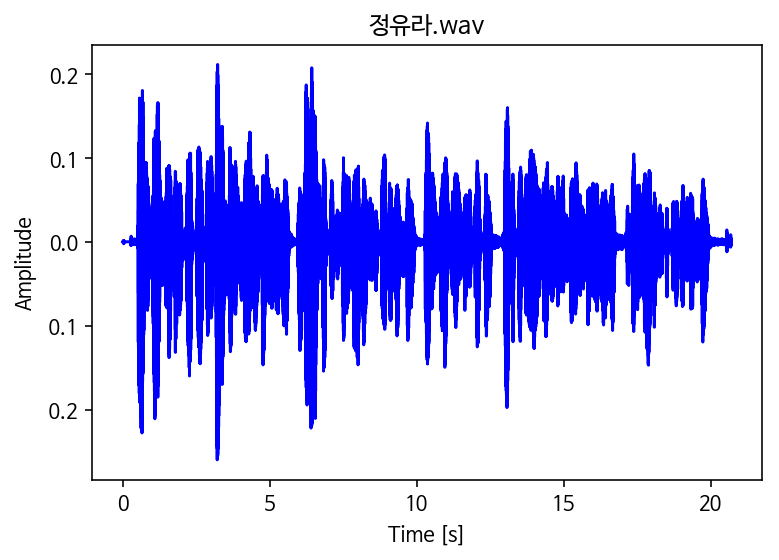

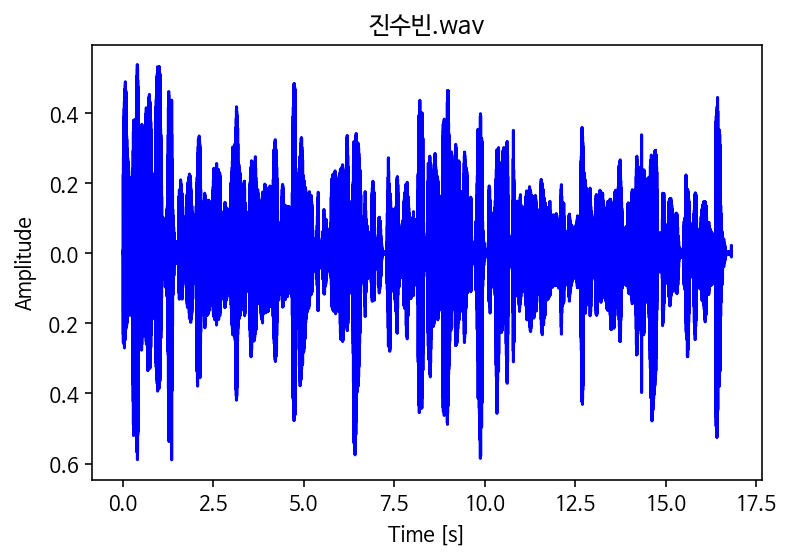

In [10]:
for data, name in zip(dataset, label): # 그래프로 파일 출력하기 (이 부분은 필요 없으니 이해하지 않아도 됨)
    y = data[0]
    sr = data[1]
    time = np.linspace(0, len(y)/sr, len(y))
    fig, ax1 = plt.subplots() # plot
    ax1.plot(time, y, color = 'b', label='speech waveform')
    ax1.set_ylabel("Amplitude") # y 축
    ax1.set_xlabel("Time [s]") # x 축
    plt.title(name)
    plt.show()

In [11]:
duration = []
for data, name in zip(dataset, label): # wav 파일 몇초인지 출력하기 (이 부분은 필요 없으니 이해하지 않아도 됨)
    print(name, librosa.get_duration(data[0], data[1]))
    duration.append(int(librosa.get_duration(data[0], data[1])))

15김지수.wav 19.3308125
17김지수.wav 21.2380625
김규리.wav 18.33725
김기백.wav 17.5265625
김재영.wav 16.927
박소연.wav 21.7215
신현욱.wav 16.862625
이수진.wav 19.5005
이정민.wav 16.6814375
전지민.wav 19.6681875
정유라.wav 20.71
진수빈.wav 16.8171875


In [12]:
print(duration)

[19, 21, 18, 17, 16, 21, 16, 19, 16, 19, 20, 16]


In [13]:
sec = 16000 # 16000Hz이기 때문에 y, sr로 불러온 wav 파일의 y의 길이를 16000으로 나누면 몇초인지 나옴

In [15]:
folder = 'C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일/' # 4초로 나눈 파일을 저장할 경로

for data, name, dur in zip(dataset, label, duration): # 모든 데이터와 그 이름에 대해서
    y, sr = data # y, sr 데이터에 대해서 
    for i in range(dur - 4): # 0~12
        cutted_y = y[i*sec:(i+4)*sec] # y를 i ~ i+4 초로 자르기
        cutted_name = name[:-4] # 이름에서 .wav를 뺐습니다. (중요하지 않음)
        sf.write(folder+cutted_name+str(i+1)+'.wav', cutted_y, sr, 'PCM_16') # librose는 16bit로 저장이 안돼서 바꿈

In [16]:
dataset_folder = 'C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일/' # 4초로 나눈 파일이 저장된 경로
files = paths.list_files(dataset_folder)

dataset = []
label = []
for l in files: # 모든 파일에 대하여 
    y, sr = librosa.load(l, sr=16000)
    dataset.append([y, sr]) # 4초로 자른 파일들을 모두 dataset에 저장 
    name = os.path.basename(l) # 이름도 저장
    name = name[:-5]
    if name[-1] == '1': # 이름을 위치로 자르니 김민주1.wav는 김민주로 잘리지만 김민주12.wav는 김민주1로 잘려서 한번 더 잘라줌
        name = name[:-1]
    label.append(name)

In [17]:
mfcc_data = []
for data in dataset: # dataset에 저장한 모든 데이터에 대해서 
    audio_mfcc = librosa.feature.mfcc(y=data[0], sr=data[1]) # mfcc로 특징값을 추출해서 mfcc_data라는 리스트에 저장함
    mfcc_data.append(audio_mfcc.reshape(-1))

In [18]:
X = mfcc_data # 이름을 보기좋게 X, y에 저장함
y = label

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) 
# 검증을 위해서 데이터의 75%만 학습시키고 남은 25%는 성능 측정에 사용하기 위해서 train, test로 나눔

In [20]:
# SVM에 들어갈 parameter를 설정해줘야하는데, 어떤게 제일 좋은 결과가 나올지 몰라서 GridSearchCV를 이용해서 
# kernel, C, gamma 여러개 중에서 뭐가 제일 잘나오는지 검사함
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 5, 10, 50], 'gamma':('auto', 'scale', 'auto_deprecated')}
svc = SVC() # SVM 불러오기
clf = GridSearchCV(svc, parameters, cv=5) # GridSearch 불러오기
clf.fit(X_train, y_train) # 학습시키기

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [0.1, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 5, 10, 50], 'gamma': ('auto', 'scale', 'auto_deprecated')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
y_predict = clf.predict(X_test) # 아까 분류해놓은 25%의 테스트 데이터로 예측값 내기

In [22]:
accuracy_score(y_test, y_predict) # 정확도 : 100

1.0

In [23]:
joblib.dump(clf, 'saved_model.pkl') # 학습시킨 모델 저장하기 (안중요함)

['saved_model.pkl']

In [24]:
def get_result(input_wav): # 마지막 테스트때 쉽게 함수에 넣으면 결과가 나오도록 하기 위해서 만든 함수 (안중요함)
    clf_load = joblib.load('saved_model.pkl') 
    y, sr = librosa.load(input_wav, sr=16000)
    cutted_y = y[0*16000:4*16000]
    librosa.output.write_wav('test.wav', cutted_y, sr)
    y, sr = librosa.load('test.wav', sr=16000)
    audio_mfcc = librosa.feature.mfcc(y=y, sr=sr)
    x_test = audio_mfcc.reshape(-1)
    print(clf_load.predict([x_test]))

In [25]:
def get_result_of_specific_time(input_wav, start, end): # 마지막 테스트때 쉽게 함수에 넣으면 결과가 나오도록 하기 위해서 만든 함수 (안중요함)
    clf_load = joblib.load('saved_model.pkl') 
    y, sr = librosa.load(input_wav, sr=16000)
    cutted_y = y[int(start*16000):int(end*16000)]
    librosa.output.write_wav('test.wav', cutted_y, sr)
    y, sr = librosa.load('test.wav', sr=16000)
    audio_mfcc = librosa.feature.mfcc(y=y, sr=sr)
    x_test = audio_mfcc.reshape(-1)
    print(clf_load.predict([x_test]))

In [26]:
dataset_folder = 'C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일' # 4초로 나눈 파일이 저장된 경로
files = paths.list_files(dataset_folder)

for l in files:
    print(l)
    get_result(l)

C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수1.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수10.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수11.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수12.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수13.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수14.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수15.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수2.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수3.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수4.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수5.wav
['15김지수']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\15김지수6.wav
['15김지수']
C:/Users/u

['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이수진15.wav
['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이수진2.wav
['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이수진3.wav
['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이수진4.wav
['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이수진5.wav
['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이수진6.wav
['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이수진7.wav
['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이수진8.wav
['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이수진9.wav
['이수진']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이정민1.wav
['이정민']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이정민10.wav
['이정민']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/4초파일\이정민11.wav
['이정민']
C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음

In [27]:
get_result_of_specific_time('C:/Users/user/Documents/민주/공부/3 - 2/디지털사운드/팀플2/모듈2_녹음파일/17김지수.wav', 3.5, 7.5 ) # 이렇게하면 검사 가능

['17김지수']


In [28]:
# SVM에 들어갈 parameter를 설정해줘야하는데, 어떤게 제일 좋은 결과가 나올지 몰라서 GridSearchCV를 이용해서 
# kernel, C, gamma 여러개 중에서 뭐가 제일 잘나오는지 검사함
parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 5, 10, 50], 'gamma':('auto', 'scale', 'auto_deprecated')}
svc = SVC() # SVM 불러오기
clf = GridSearchCV(svc, parameters, cv=5) # GridSearch 불러오기
clf.fit(X, y) # 학습시키기

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [0.1, 0.5, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 5, 10, 50], 'gamma': ('auto', 'scale', 'auto_deprecated')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [29]:
joblib.dump(clf, 'saved_model.pkl') # 학습시킨 모델 저장하기 (안중요함)

['saved_model.pkl']